In [1]:
using GaussianFilters

using LinearAlgebra
using Distributions
using Random

Random.seed!(10);

In this example, a satellite is rotating freely, we must try to estimate rotation rates. We can add torque $u$ along each axis. Principal moments of interia are capured in $J$.

In [2]:
# nonlinear dynamics function. must be a function of both states (x) and actions (u) even if either are not used.
dt = 0.001
J = [1; 5; 5]
function step(x,u)
    xp = x + dt*u./J
    xp[1] += dt*(J[2]-J[3])/J[1]*x[2]*x[3]
    xp[2] += dt*(J[3]-J[1])/J[2]*x[3]*x[1]
    xp[3] += dt*(J[1]-J[2])/J[3]*x[1]*x[2]
    return xp
end    

W = 0.001*Matrix{Float64}(I,3,3)

# build dynamics model
dmodel = NonlinearDynamicsModel(step,W);

We get a noisy estimate of rotation rates, but our measurements also saturate above/below some constant $\pm c$.

In [3]:
# nonlinear observation function. must be a function of both states (x) and actions (u) even if either are not used.
c=10
function observe(x,u)
    y = x
    y = min.(y,c)
    y = max.(y,-c)
    return y
end

V = 0.3*Matrix{Float64}(I,3,3)

# build observation model
omodel = NonlinearObservationModel(observe,V)

# build ekf
ekf = ExtendedKalmanFilter(dmodel,omodel);

Initialize belief, generate action sequence (in this case of applying no torque), simulate model.

In [4]:
times = 0:dt:5
action_sequence = [[0.0,0.0,0.0] for t in times]

b0 = GaussianBelief([10.0,0.0,0.0], Matrix{Float64}(I,3,3))

sim_states, sim_measurements = simulation(ekf,b0,action_sequence);

Run filter on simulated data

In [5]:
filtered_beliefs = run_filter(ekf, b0, action_sequence, sim_measurements)

# turn array of belief structs into simple tensors.
μ, Σ = unpack(filtered_beliefs); 

### Plot

In [6]:
using Plots

Truth:

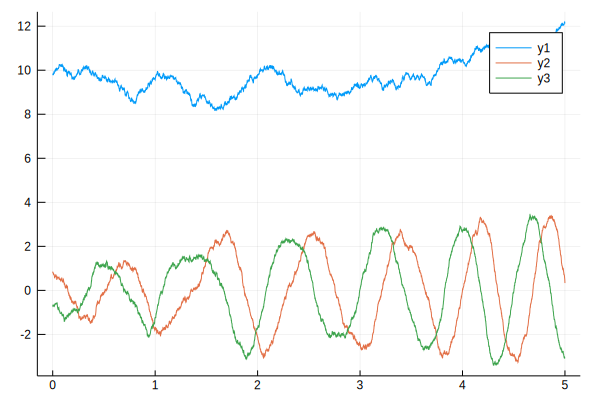

In [7]:
plot(times,hcat(sim_states[2:end]...)')

With State Estimates:

Our measurement noise is pretty high, yet this still tracks really well. Uncertainty in the beginning because of high initial belief. Once $\omega 1$ (top) is tracked well, it only loses track when the true value of w1 goes above the saturation threshold $c=10$. $\omega 2$ and $\omega 3$ are tracked pretty well consistently.

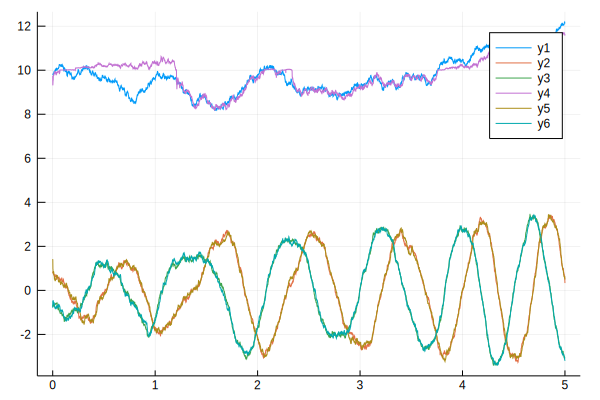

In [8]:
plot!(times,μ[2:end,:])